# Cis Effects 8p

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from cnvutils import *
import statsmodels.stats.multitest
import cptac.utils

In [2]:
cptac.download(dataset='lscc')

True

In [3]:
luad = cptac.Luad()
hnscc = cptac.Hnscc()
ovarian = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
lscc = cptac.Lscc()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-3-057fd76044c6>, line 2)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-3-057fd76044c6>, line 6)


In [4]:
proteomics = {
    'luad': luad.get_proteomics(),
    'hnscc': hnscc.get_proteomics(),
    'ovarian': ovarian.get_proteomics(),
    'colon': colon.get_proteomics(),
    'brca': brca.get_proteomics(),
    'lscc': lscc.get_proteomics()
}

In [5]:
cnv = {
    'luad': luad.get_CNV(),
    'hnscc': hnscc.get_CNV(),
    'ovarian': ovarian.get_CNV(),
    'colon': colon.get_CNV(),
    'brca': brca.get_CNV(),
    'lscc': lscc.get_CNV()
}

In [6]:
transcriptomics = {
    'luad': luad.get_transcriptomics(),
    'hnscc': hnscc.get_transcriptomics(),
    'ovarian': ovarian.get_transcriptomics(),
    'colon': colon.get_transcriptomics(),
    'brca': brca.get_transcriptomics(),
    'lscc': lscc.get_transcriptomics()
}

## Get Locations

In [7]:
locations = get_gene_locations()

In [8]:
CHROMOSOME = '8'
ARM = 'p'
EVENT_START = 0
EVENT_END = 30794385

In [9]:
locations

,,chromosome,start_bp,end_bp,arm
Name,Database_ID,,,,
SPTLC1P3,NaN,6,63227485.0,63227743.0,q
LLGL1,ENSG00000131899.6,17,18225635.0,18244875.0,p
DUX4L1,NaN,4,190084412.0,190085686.0,q
RBM18,ENSG00000119446.9,9,122237622.0,122264840.0,q
KRT18P53,NaN,X,545236.0,545352.0,p
...,...,...,...,...,...
PRPF38B,NaN,1,108692310.0,108702928.0,p
OR7E29P,NaN,3,125712139.0,125713045.0,q
TK1,ENSG00000167900.11,17,78174091.0,78187233.0,q


In [10]:
subset_event = locations[(locations.chromosome == CHROMOSOME) & (locations.arm == ARM) & (locations.start_bp >= EVENT_START) & (locations.end_bp <= EVENT_END)]
genes = set(subset_event.index.get_level_values('Name'))

## Run Pearson Correlations

In [11]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

In [12]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [13]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\

In [14]:
all_results = transcriptomics_results.join(proteomics_results)

In [15]:
all_results.to_csv('pearson_cis_effect_results_8p.tsv', sep='\t')

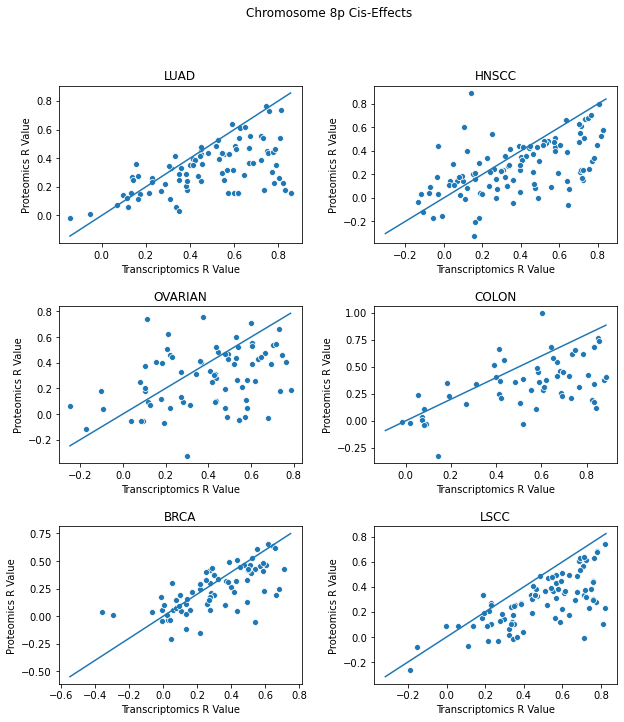

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8p Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("Transcriptomics R Value")
    axs[count//2][count%2].set_ylabel("Proteomics R Value")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)